**Considered problem:** In this notebook, we predict the yield per year for several different countries and cultures.

**Research question:** The goal of this work is to compare different forecasting methods. We will begin by very simple and naive ones, which are however used a lot in practice, such as a moving average. Then, we will compare it with more complex methods, some machine learning models. The choice of the models tested will be determined by looking at the data. The main obstacle for those methods will be the little information contained in the dataset.

The notebook is structured as follows:

<a id='top'></a>
[1. Data Inspection, Clean-Up & Preprocessing](#data) <br>
[2. Naive Approaches](#naive) <br>
&emsp; [2.1 Using only the past year value](#past_year) <br>
&emsp; [2.2 Moving average](#moving) <br>
&emsp; [2.3 Exponential smoothing](#expsmo) <br>
[3. Machine Learning methods](#ml) <br>
&emsp; [3.1 Gradient boosting](#gb) <br>
&emsp; [3.2 Feedforward Neural Networks](#fnn) <br>
[4. Conclusion](#conclusion) <br>
&emsp; [4.1 Summary](#summary) <br>
&emsp; [4.2 Further Ideas](#ideas) <br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore', message='Optimization failed to converge')
warnings.filterwarnings('ignore', message='Boolean Series key will be reindexed to match DataFrame index')
warnings.filterwarnings(action='ignore', category=FutureWarning)

# 1. Data Inspection, Clean-Up & Preprocessing <a id='data'></a>
[to the top](#top)

In [2]:
yield_df_gross = pd.read_csv('data/yield_df.csv')

In [3]:
yield_df = yield_df_gross.copy()

In [4]:
yield_df = yield_df[['Area', 'Item', 'Year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']] ## It just drops a column of index. It was unnamed so .drop didn't work

In [5]:
yield_df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


The dataset we will work with consists of three "base" columns (Area, Item, and Year), three features and the target (hg/ha_yield). It contains data from 1990 to 2013 in different countries for several items. We will have to face two main obstacles : there is not a large amount of data and there are only three features.

In [6]:
yield_df.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


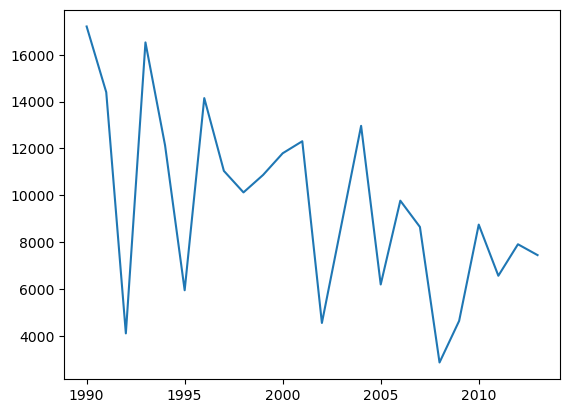

In [7]:
afg_maize = yield_df[(yield_df['Area'] == 'Zimbabwe') & (yield_df['Item'] == 'Maize')][['Year', 'hg/ha_yield']]
plt.plot(afg_maize['Year'], afg_maize['hg/ha_yield'])
plt.show()

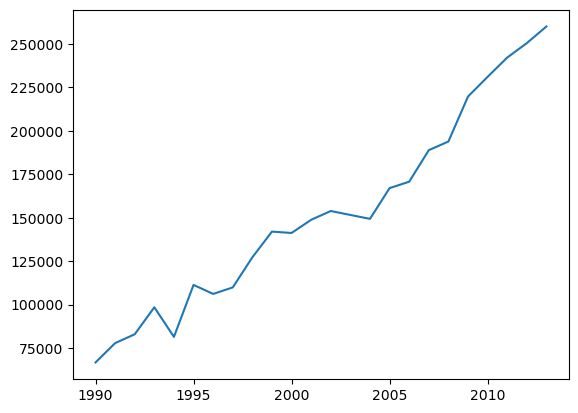

In [8]:
alb_potatoes = yield_df[(yield_df['Area'] == 'Albania') & (yield_df['Item'] == 'Potatoes')][['Year', 'hg/ha_yield']]
plt.plot(alb_potatoes['Year'], alb_potatoes['hg/ha_yield'])
plt.show()

We can see that the time series are very different. I picked two random areas and items for these examples. Actually, this is very logical. Each area and each item is affected by different economic or environmental contexts. Then, applying classical time series methods like SARIMAX will be very difficult. We would have to do all the work (stationnarity, seasonnality, acf, pacf...) for each of the 1182 time series. This is impossible so we will focus on naive methods and Machine Learning.

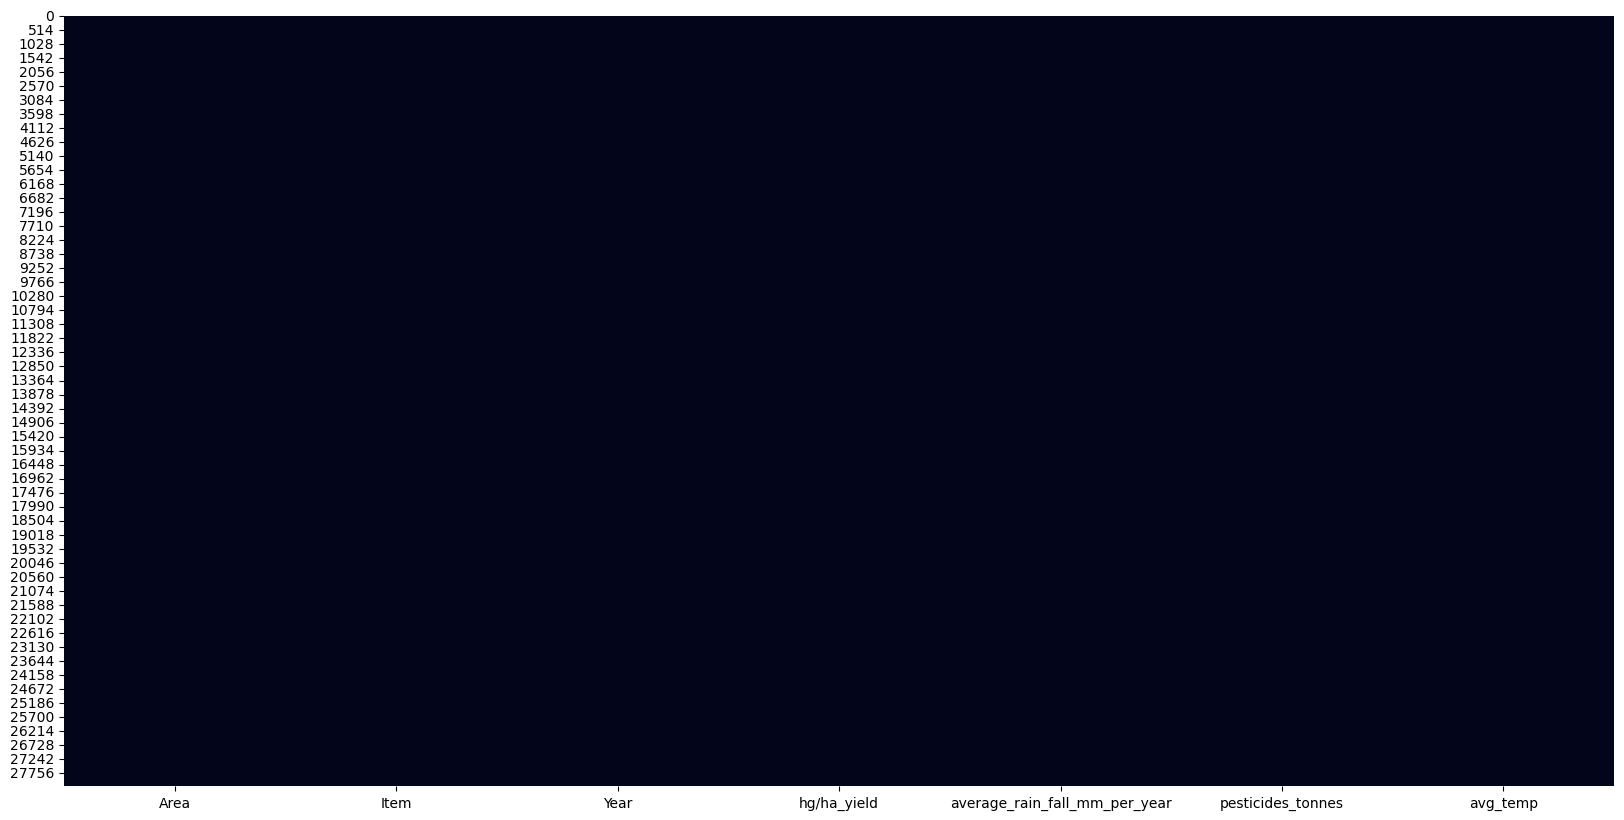

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(yield_df.isna(), cbar=False)
plt.show()

It seems that there is not any NaN value in the dataset. This is very convenient. We can check that to be absolutely sure :

In [10]:
yield_df[yield_df.isna().any(axis=1)]

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp


We will now make a bit of preprocessing and clean-up. When forecasting the yield, we do not know what will the average temperature be. So, we have to make a shift in order to build some ML models later.

In [11]:
yield_df['hg/ha_yield at Y+1'] = yield_df.groupby(['Area','Item'])['hg/ha_yield'].shift(periods=-1)
yield_df['pesticides_tonnes at Y+1'] = yield_df.groupby(['Area','Item'])['pesticides_tonnes'].shift(periods=-1)
yield_df = yield_df.drop('hg/ha_yield', axis = 1)
yield_df = yield_df.drop('pesticides_tonnes', axis = 1)

Unfortunately, shifting some columns causes the loss of one year of data.

In [12]:
yield_df = yield_df[yield_df['Year'] != 2013]

In [13]:
yield_df

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,hg/ha_yield at Y+1,pesticides_tonnes at Y+1
0,Albania,Maize,1990,1485.0,16.37,29068.0,121.00
1,Albania,Potatoes,1990,1485.0,16.37,77818.0,121.00
2,Albania,"Rice, paddy",1990,1485.0,16.37,28538.0,121.00
3,Albania,Sorghum,1990,1485.0,16.37,6667.0,121.00
4,Albania,Soybeans,1990,1485.0,16.37,6066.0,121.00
...,...,...,...,...,...,...,...
28229,Zimbabwe,"Rice, paddy",2012,657.0,20.52,22581.0,2550.07
28230,Zimbabwe,Sorghum,2012,657.0,20.52,3066.0,2550.07
28231,Zimbabwe,Soybeans,2012,657.0,20.52,13142.0,2550.07
28232,Zimbabwe,Sweet potatoes,2012,657.0,20.52,22222.0,2550.07


In [14]:
yield_df[(yield_df['Area'] == 'Argentina') & (yield_df['Item'] == 'Cassava')]

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,hg/ha_yield at Y+1,pesticides_tonnes at Y+1
377,Argentina,Cassava,1990,591.0,17.46,100000.0,26156.00
378,Argentina,Cassava,1990,591.0,17.67,100000.0,26156.00
393,Argentina,Cassava,1991,591.0,17.64,100000.0,26156.00
394,Argentina,Cassava,1991,591.0,17.86,100000.0,26156.00
409,Argentina,Cassava,1992,591.0,17.09,100000.0,26156.00
410,Argentina,Cassava,1992,591.0,17.51,100000.0,26156.00
425,Argentina,Cassava,1993,591.0,17.32,100000.0,26156.00
426,Argentina,Cassava,1993,591.0,17.53,100000.0,30195.00
441,Argentina,Cassava,1994,591.0,18.17,100000.0,30195.00
442,Argentina,Cassava,1994,591.0,18.31,100000.0,37842.00


The example of Cassava in Argentina shows that there is a duplicate problem. Some of the rows are doubled with different average temperatures. We have to groupby the "base" columns :

In [15]:
yield_df = yield_df.groupby(['Area','Item','Year']).mean().reset_index()

In [16]:
yield_df.groupby(['Area','Item']).count()

Year  average_rain_fall_mm_per_year  avg_temp  \
Area     Item                                                            
Albania  Maize             22                             22        22   
         Potatoes          22                             22        22   
         Rice, paddy        4                              4         4   
         Sorghum            3                              3         3   
         Soybeans          22                             22        22   
...                       ...                            ...       ...   
Zimbabwe Rice, paddy       22                             22        22   
         Sorghum           22                             22        22   
         Soybeans          22                             22        22   
         Sweet potatoes    22                             22        22   
         Wheat             22                             22        22   

                         hg/ha_yield at Y+1  pesticides_tonnes at Y+1  
Area     Item                                                          
Albania  Maize                           22                        22  
         Potatoes                        22                        22  
         Rice, paddy                      3                         3  
         Sorghum                          2                         2  
         Soybeans                        22                        22  
...                                     ...                       ...  
Zimbabwe Rice, paddy                     22                        22  
         Sorghum                         22                        22  
         Soybeans                        22                        22  
         Sweet potatoes                  22                        22  
         Wheat                           22                        22  

[598 rows x 5 columns]

We can see here an other problem. Some items in some countries does not have the full history in the dataset. I choose to keep only the complete ones :

In [17]:
yield_df = yield_df.set_index(['Area','Item'])[yield_df.groupby(['Area','Item']).count()['hg/ha_yield at Y+1'] == 22].reset_index()

In [18]:
len(yield_df.groupby(['Area','Item']))

505

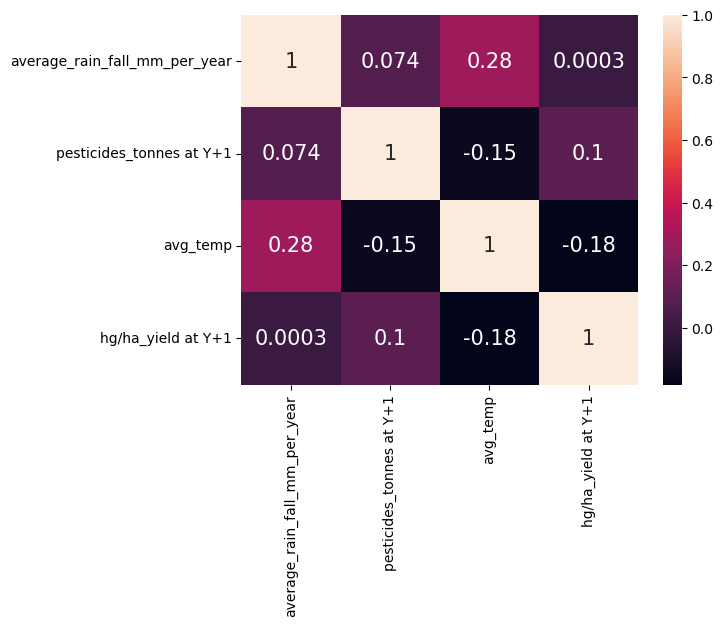

In [19]:
corr = yield_df[['average_rain_fall_mm_per_year','pesticides_tonnes at Y+1','avg_temp','hg/ha_yield at Y+1']].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'fontsize': 15})
plt.show()

We will know look at the seasonality. In order to do that, I aggregate the rows by year to look for a global seasonality/

In [20]:
yield_df_agg = yield_df.groupby(['Year']).mean()

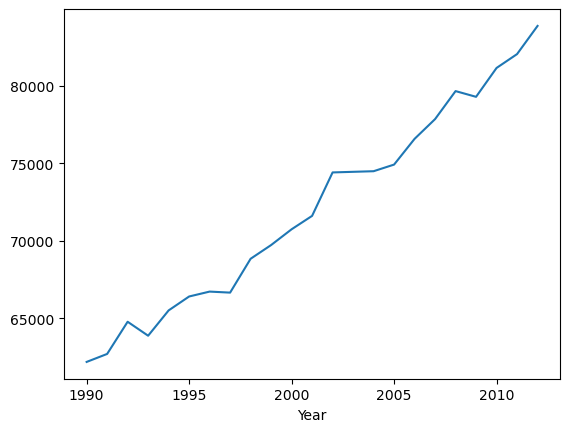

In [21]:
yield_df_agg['hg/ha_yield at Y+1'].plot()
plt.show()

The mean production (along all areas and items) is rising through the years in a linear way, almost doubling in 60 years. But, there is not any evident seasonality. We should still check that with a discrete Fourier transformation

In [22]:
fft = abs(tf.signal.rfft(yield_df_agg['hg/ha_yield at Y+1']))

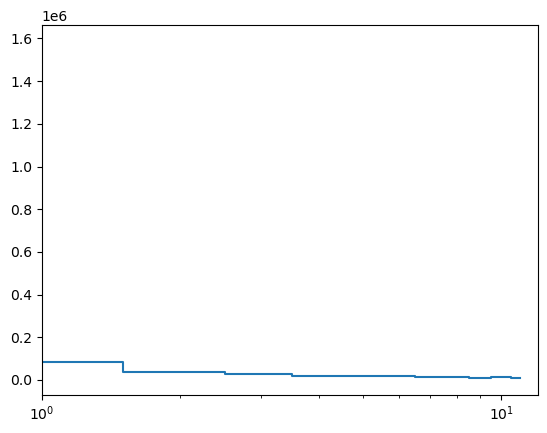

In [23]:
plt.step(np.arange(0, len(fft)), fft, where='mid')
plt.xlim(1, len(fft))
plt.xscale('log')

We cannot see any seasonnality here for the mean production. That doesn't mean that there is not some for certain time series but, as said before, we will deal with every particular case using classical time series methods.

# 2. Naive approaches <a id='naive'></a>
[to the top](#top)

## 2.1 Only using the past year value <a id='past_year'></a>
[to the top](#top)

Our first baseline will be the simplest method. It consists in using the previous period to forecast the next one. 

In [24]:
yield_df_naive = yield_df.copy()
yield_df_naive['hg/ha_yield at Y'] = yield_df_naive.groupby(['Area','Item']).shift(periods=1)['hg/ha_yield at Y+1']

In [25]:
yield_df_naive

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,hg/ha_yield at Y+1,pesticides_tonnes at Y+1,hg/ha_yield at Y
0,Albania,Maize,1990,1485.0,16.37,29068.0,121.00,NaN
1,Albania,Maize,1991,1485.0,15.36,24876.0,121.00,29068.0
2,Albania,Maize,1992,1485.0,16.06,24185.0,121.00,24876.0
3,Albania,Maize,1993,1485.0,16.05,25848.0,201.00,24185.0
4,Albania,Maize,1994,1485.0,16.96,31300.0,251.00,25848.0
...,...,...,...,...,...,...,...,...
11105,Zimbabwe,Wheat,2008,657.0,20.68,30000.0,3269.99,30097.0
11106,Zimbabwe,Wheat,2009,657.0,20.52,27681.0,3305.17,30000.0
11107,Zimbabwe,Wheat,2010,657.0,21.17,26274.0,3340.35,27681.0
11108,Zimbabwe,Wheat,2011,657.0,20.78,24420.0,3375.53,26274.0


In [26]:
yield_df_naive_test = yield_df_naive[yield_df_naive['Year'] == 2012]

In [27]:
print(f"The RMSE of the naive moving method is : {round(np.sqrt(((yield_df_naive_test['hg/ha_yield at Y+1'] - yield_df_naive_test['hg/ha_yield at Y'])**2).mean()),0)}")

The RMSE of the naive moving method is : 16464.0


This is our first baseline, the score to beat and to compare with.

## 2.2 Moving average <a id='moving'></a>
[to the top](#top)

Our second naive method is the moving average. We first have to determine the optimal window.

In [28]:
yield_df_mov = yield_df_naive.copy()

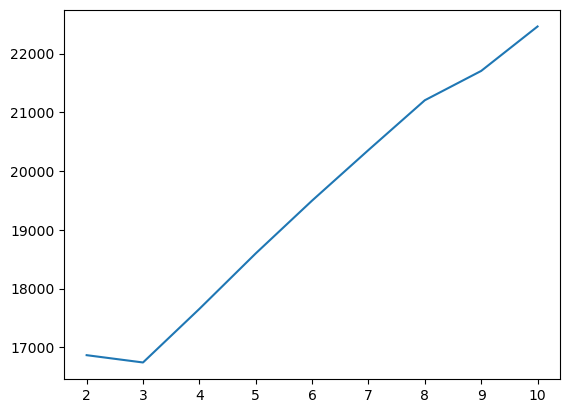

The more accurate window is : 3 years
The RMSE is then : 16744.0


In [29]:
y = []
for k in range(2,11):
    yield_df_mov[f'Moving Average {k}'] = yield_df_mov['hg/ha_yield at Y'].rolling(k).mean()
    yield_df_mov_test = yield_df_mov[yield_df_mov['Year'] == 2012]
    y.append(np.sqrt(((yield_df_mov_test['hg/ha_yield at Y+1'] - yield_df_mov_test[f'Moving Average {k}'])**2).mean()))

x = [k for k in range(2,11)]
plt.plot(x,y)
plt.show()

print(f"The more accurate window is : {y.index(min(y)) + 2} years")
print(f"The RMSE is then : {round(min(y),0)}")

The moving average doesn't beat the naive moving method. The reason behind this result is probably the linear trend of a lot of time series.

## 2.3 Exponential smoothing <a id='expsmo'></a>
[to the top](#top)

There are several types of exponential smoothing. The Holt's linear method seems to be the more suitable for our case since our time series don't have any particular seasonality but shows a trend. However, we will still first test the simple exponential smoothing

In [30]:
list_error = []
for area in yield_df['Area'].unique():
    for item in yield_df[yield_df['Area'] == area]['Item'].unique():
        df_small = yield_df[(yield_df['Area'] == area) & (yield_df['Item'] == item)]
        df_small_train = df_small[df_small['Year'] != 2012]
        df_small_test = df_small[df_small['Year'] == 2012]
        model = SimpleExpSmoothing(np.asarray(df_small_train['hg/ha_yield at Y+1']), initialization_method="estimated")

        fit = model.fit()
        pred = fit.forecast(1)
        list_error.append(int(df_small_test['hg/ha_yield at Y+1']) - int(pred))

In [31]:
print(f"The RMSE of the Simple Exponential Smoothing method is : {round(np.sqrt(np.mean([x**2 for x in list_error])),0)}")

The RMSE of the Simple Exponential Smoothing method is : 15684.0


In [32]:
list_error = []
for area in yield_df['Area'].unique():
    for item in yield_df[yield_df['Area'] == area]['Item'].unique():
        df_small = yield_df[(yield_df['Area'] == area) & (yield_df['Item'] == item)]
        df_small_train = df_small[df_small['Year'] != 2012]
        df_small_test = df_small[df_small['Year'] == 2012]
        model = Holt(np.asarray(df_small_train['hg/ha_yield at Y+1']), initialization_method="estimated")

        fit = model.fit()
        pred = fit.forecast(1)
        list_error.append(int(df_small_test['hg/ha_yield at Y+1']) - int(pred))

In [33]:
print(f"The RMSE of the Holt's Linear method is : {round(np.sqrt(np.mean([x**2 for x in list_error])),0)}")

The RMSE of the Holt's Linear method is : 17309.0


The simple exponential smoothing beat the first naive method but is surprisingly better than the Holt's Linear method, despite the linear positive trend.

# 3. Machine Learning methods <a id='ml'></a>
[to the top](#top)

Since we do not have a lot of history, I chose to focus on regressors for the machine learning methods, instead of Recurrent Neural Networks for example. So, we'll apply Gradient boosting and Feedforward Neural Networks to our problem.

## 3.1 Gradient boosting <a id='gb'></a>
[to the top](#top)

In [34]:
yield_df['Area'] = yield_df['Area'].astype('category')
yield_df['Item'] = yield_df['Item'].astype('category')

In [35]:
train = yield_df[yield_df['Year'] < 2011]
_eval = yield_df[yield_df['Year'] == 2011]
test = yield_df[yield_df['Year'] == 2012]

X_train = train.drop('hg/ha_yield at Y+1', axis=1)
y_train = train['hg/ha_yield at Y+1']
X_eval = _eval.drop('hg/ha_yield at Y+1', axis=1)
y_eval = _eval['hg/ha_yield at Y+1']
X_test = test.drop('hg/ha_yield at Y+1', axis = 1)
y_test = test['hg/ha_yield at Y+1']

In [36]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

In [37]:
params = {}

In [38]:
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 711
[LightGBM] [Info] Number of data points in the train set: 10100, number of used features: 6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 70904.734318
[1]	valid_0's l2: 6.62269e+09
[2]	valid_0's l2: 5.67649e+09
[3]	valid_0's l2: 4.88679e+09
[4]	valid_0's l2: 4.21087e+09
[5]	valid_0's l2: 3.64167e+09
[6]	valid_0's l2: 3.18776e+09
[7]	valid_0's l2: 2.80573e+09
[8]	valid_0's l2: 2.47893e+09
[9]	valid_0's l2: 2.21461e+09
[10]	valid_0's l2: 1.99724e+09
[11]	valid_0's l2: 1.79448e+09
[12]	valid_0's l2: 1.63834e+09
[13]	valid_0's l2: 1.49373e+09
[14]	valid_0's l2: 1.37721e+09
[15]

C:\Users\Utilisateur\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Utilisateur\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[54]	valid_0's l2: 4.10027e+08
[55]	valid_0's l2: 4.0312e+08
[56]	valid_0's l2: 3.99811e+08
[57]	valid_0's l2: 3.9509e+08
[58]	valid_0's l2: 3.92944e+08
[59]	valid_0's l2: 3.90149e+08
[60]	valid_0's l2: 3.88878e+08
[61]	valid_0's l2: 3.86093e+08
[62]	valid_0's l2: 3.82505e+08
[63]	valid_0's l2: 3.7931e+08
[64]	valid_0's l2: 3.79035e+08
[65]	valid_0's l2: 3.7911e+08
[66]	valid_0's l2: 3.78621e+08
[67]	valid_0's l2: 3.78103e+08
[68]	valid_0's l2: 3.75388e+08
[69]	valid_0's l2: 3.72804e+08
[70]	valid_0's l2: 3.70138e+08
[71]	valid_0's l2: 3.68695e+08
[72]	valid_0's l2: 3.67575e+08
[73]	valid_0's l2: 3.66204e+08
[74]	valid_0's l2: 3.64371e+08
[75]	valid_0's l2: 3.62585e+08
[76]	valid_0's l2: 3.60751e+08
[77]	valid_0's l2: 3.60059e+08
[78]	valid_0's l2: 3.5893e+08
[79]	valid_0's l2: 3.56913e+08
[80]	valid_0's l2: 3.55582e+08
[81]	valid_0's l2: 3.54329e+08
[82]	valid_0's l2: 3.52797e+08
[83]	valid_0's l2: 3.51549e+08
[84]	valid_0's l2: 3.51271e+08
[85]	valid_0's l2: 3.497e+08
[86]	valid_0's 

In [39]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)**(0.5)
print(f"The first RMSE we got with LightGBM is {round(mean_squared_error(y_test, y_pred)**(0.5),0)}")

The first RMSE we got with LightGBM is 22391.0


This is pretty bad, the worst we got so far, but we will try to improve that with a bit of feature engineering and hyperparameter tuning.

In [40]:
yield_df_eng = yield_df.copy()

I tried different feature constructions -still simple though- and the best configuration seems to be the following :

In [41]:
yield_df_eng['avg_temp at Y-1'] = yield_df_eng['avg_temp'].shift(1)
yield_df_eng['avg_temp at Y-2'] = yield_df_eng['avg_temp'].shift(2)
yield_df_eng['avg_temp at Y-3'] = yield_df_eng['avg_temp'].shift(3)
yield_df_eng['mean avg_temp for 10 years'] = yield_df_eng['avg_temp'].rolling(10).mean()

yield_df_eng['pesticides_tonnes at Y'] = yield_df_eng['pesticides_tonnes at Y+1'].shift(1)
yield_df_eng['pesticides_tonnes at Y-1'] = yield_df_eng['pesticides_tonnes at Y+1'].shift(2)
yield_df_eng['pesticides_tonnes at Y-2'] = yield_df_eng['pesticides_tonnes at Y+1'].shift(3)
yield_df_eng['mean pesticides_tonnes for 10 years'] = yield_df_eng['pesticides_tonnes at Y+1'].rolling(10).mean()

yield_df_eng['hg/ha_yield at Y'] = yield_df_eng['hg/ha_yield at Y+1'].shift(1)
yield_df_eng['hg/ha_yield at Y-1'] = yield_df_eng['hg/ha_yield at Y+1'].shift(2)
yield_df_eng['hg/ha_yield at Y-2'] = yield_df_eng['hg/ha_yield at Y+1'].shift(3)
yield_df_eng['mean hg/ha_yield for 5 years'] = yield_df_eng['hg/ha_yield at Y+1'].rolling(5).mean()
yield_df_eng['mean hg/ha_yield for 10 years'] = yield_df_eng['hg/ha_yield at Y+1'].rolling(10).mean()

In [42]:
yield_df_eng

,Area,Item,Year,average_rain_fall_mm_per_year,avg_temp,hg/ha_yield at Y+1,pesticides_tonnes at Y+1,avg_temp at Y-1,avg_temp at Y-2,avg_temp at Y-3,mean avg_temp for 10 years,pesticides_tonnes at Y,pesticides_tonnes at Y-1,pesticides_tonnes at Y-2,mean pesticides_tonnes for 10 years,hg/ha_yield at Y,hg/ha_yield at Y-1,hg/ha_yield at Y-2,mean hg/ha_yield for 5 years,mean hg/ha_yield for 10 years
0,Albania,Maize,1990,1485.0,16.37,29068.0,121.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,Maize,1991,1485.0,15.36,24876.0,121.00,16.37,NaN,NaN,NaN,121.00,NaN,NaN,NaN,29068.0,NaN,NaN,NaN,NaN
2,Albania,Maize,1992,1485.0,16.06,24185.0,121.00,15.36,16.37,NaN,NaN,121.00,121.00,NaN,NaN,24876.0,29068.0,NaN,NaN,NaN
3,Albania,Maize,1993,1485.0,16.05,25848.0,201.00,16.06,15.36,16.37,NaN,121.00,121.00,121.00,NaN,24185.0,24876.0,29068.0,NaN,NaN
4,Albania,Maize,1994,1485.0,16.96,31300.0,251.00,16.05,16.06,15.36,NaN,201.00,121.00,121.00,NaN,25848.0,24185.0,24876.0,27055.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11105,Zimbabwe,Wheat,2008,657.0,20.68,30000.0,3269.99,20.75,20.70,21.49,20.789,3234.81,3199.63,3164.45,3097.602,30097.0,29998.0,36000.0,32219.0,40809.5
11106,Zimbabwe,Wheat,2009,657.0,20.52,27681.0,3305.17,20.68,20.75,20.70,20.711,3269.99,3234.81,3199.63,3136.301,30000.0,30097.0,29998.0,30755.2,38077.6
11107,Zimbabwe,Wheat,2010,657.0,21.17,26274.0,3340.35,20.52,20.68,20.75,20.784,3305.17,3269.99,3234.81,3175.000,27681.0,30000.0,30097.0,28810.0,35305.0
11108,Zimbabwe,Wheat,2011,657.0,20.78,24420.0,3375.53,21.17,20.52,20.68,20.834,3340.35,3305.17,3269.99,3213.699,26274.0,27681.0,30000.0,27694.4,32447.0


In [43]:
train = yield_df_eng[yield_df_eng['Year'] < 2011]
_eval = yield_df_eng[yield_df_eng['Year'] == 2011]
test = yield_df_eng[yield_df_eng['Year'] == 2012]

X_train = train.drop('hg/ha_yield at Y+1', axis=1)
y_train = train['hg/ha_yield at Y+1']
X_eval = _eval.drop('hg/ha_yield at Y+1', axis=1)
y_eval = _eval['hg/ha_yield at Y+1']
X_test = test.drop('hg/ha_yield at Y+1', axis = 1)
y_test = test['hg/ha_yield at Y+1']

In [44]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)

In [45]:
params = {}

In [46]:
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 10100, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 70904.734318
[1]	valid_0's l2: 6.35885e+09
[2]	valid_0's l2: 5.20386e+09
[3]	valid_0's l2: 4.2637e+09
[4]	valid_0's l2: 3.4912e+09
[5]	valid_0's l2: 2.86711e+09
[6]	valid_0's l2: 2.3638e+09
[7]	valid_0's l2: 1.95023e+09
[8]	valid_0's l2: 1.60983e+09
[9]	valid_0's l2: 1.33844e+09
[10]	valid_0's l2: 1.11543e+09
[11]	valid_0's l2: 9.38108e+08
[12]	valid_0's l2: 7.91882e+08
[13]	valid_0's l2: 6.73358e+08
[14]	valid_0's l2: 5.77697e+08
[15]	valid_0's l2: 5.03799e+08
[16]	valid_0's l2: 4.39722e+08
[17]	va

C:\Users\Utilisateur\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Utilisateur\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[62]	valid_0's l2: 1.73611e+08
[63]	valid_0's l2: 1.73564e+08
[64]	valid_0's l2: 1.72566e+08
[65]	valid_0's l2: 1.72282e+08
[66]	valid_0's l2: 1.72662e+08
[67]	valid_0's l2: 1.72528e+08
[68]	valid_0's l2: 1.73433e+08
[69]	valid_0's l2: 1.73998e+08
[70]	valid_0's l2: 1.73974e+08
[71]	valid_0's l2: 1.73939e+08
[72]	valid_0's l2: 1.73951e+08
[73]	valid_0's l2: 1.72926e+08
[74]	valid_0's l2: 1.73911e+08
[75]	valid_0's l2: 1.73198e+08
[76]	valid_0's l2: 1.73517e+08
[77]	valid_0's l2: 1.74205e+08
[78]	valid_0's l2: 1.74299e+08
[79]	valid_0's l2: 1.74438e+08
[80]	valid_0's l2: 1.73915e+08
[81]	valid_0's l2: 1.73928e+08
[82]	valid_0's l2: 1.741e+08
[83]	valid_0's l2: 1.74017e+08
[84]	valid_0's l2: 1.73417e+08
[85]	valid_0's l2: 1.74019e+08
[86]	valid_0's l2: 1.74042e+08
[87]	valid_0's l2: 1.75026e+08
[88]	valid_0's l2: 1.7464e+08
[89]	valid_0's l2: 1.74517e+08
[90]	valid_0's l2: 1.74759e+08
[91]	valid_0's l2: 1.75039e+08
[92]	valid_0's l2: 1.75457e+08
[93]	valid_0's l2: 1.75395e+08
[94]	valid_

In [47]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)**(0.5)
print(f"After building some new features, the RMSE is now : {round(mean_squared_error(y_test, y_pred)**(0.5),0)}")

After building some new features, the RMSE is now : 14609.0


Even with such a simple feature engineering, the RMSE has decreased a lot and is the best result we got so far. The next phase is now the hyperparameter tuning. The parameters values here are the last I tested, not the only ones obviously.

In [48]:
param_test ={'num_leaves': [25,28,30,32,35], 
             'min_child_samples': [3,5,7,10,12,15,20], 
             'min_child_weight': [5e-3, 7e-3, 1e-3, 3e-2, 5e-2],
             'colsample_bytree': [0.7,0.75,0.8,0.85,0.9,0.95,1],
             'n_estimators': [70,80,90,100,110,120,130],
             'max_depth':[20,24,28,30,32,36,40]}

In [49]:
clf = lgb.LGBMRegressor()
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=3,
    refit=True,
    verbose=True)

In [50]:
gs.fit(X_train, y_train)
print(f'Best score reached: {round(np.abs(gs.best_score_),0)} with params: {gs.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best score reached: 14093.0 with params: {'num_leaves': 30, 'n_estimators': 110, 'min_child_weight': 0.001, 'min_child_samples': 12, 'max_depth': 28, 'colsample_bytree': 0.9}


In [51]:
clf = lgb.LGBMRegressor(num_leaves = 30, n_estimators = 110, min_child_weight = 0.001, min_child_samples = 12, max_depth = 28, colsample_bytree = 0.9)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"After this phase of hyperparameter tuning, the RMSE is now : {round(mean_squared_error(y_test, y_pred)**(0.5),0)}")

After this phase of hyperparameter tuning, the RMSE is now : 14994.0


Surprisingly, I was not able to improve the RMSE with some hyperparameter tuning. I really do not understand it.

## 3.2 Feedforward Neural Networks <a id='fnn'></a>
[to the top](#top)

Our dataset is pretty small so FNNs may be a good choice despite their computing time issues. But I will have to pay attention to overfitting of course. I chose to keep the new features introduced in the last part.

In [52]:
yield_df_eng_le = yield_df_eng.copy()

Contrary to LightGBM, I have to fill the NaNs with tensorflow. I used the mean. This part could probably be improved.

In [53]:
yield_df_eng_le[['Year', 'average_rain_fall_mm_per_year', 'avg_temp',
       'hg/ha_yield at Y+1', 'pesticides_tonnes at Y+1', 'avg_temp at Y-1',
       'avg_temp at Y-2', 'avg_temp at Y-3', 'mean avg_temp for 10 years',
       'pesticides_tonnes at Y', 'pesticides_tonnes at Y-1',
       'pesticides_tonnes at Y-2', 'mean pesticides_tonnes for 10 years',
       'hg/ha_yield at Y', 'hg/ha_yield at Y-1', 'hg/ha_yield at Y-2',
       'mean hg/ha_yield for 5 years', 'mean hg/ha_yield for 10 years']] = yield_df_eng_le.groupby(['Area','Item']).transform(lambda x: x.fillna(x.mean()))

I also have to convert the categorical columns into dummies.

In [54]:
yield_df_eng_le = pd.get_dummies(yield_df_eng_le, columns=['Area','Item'], prefix='', prefix_sep='')

In [55]:
train = yield_df_eng_le[yield_df_eng_le['Year'] < 2012]
test = yield_df_eng_le[yield_df_eng_le['Year'] == 2012]

X_train = train.drop('hg/ha_yield at Y+1', axis=1)
y_train = train['hg/ha_yield at Y+1']
X_test = test.drop('hg/ha_yield at Y+1', axis = 1)
y_test = test['hg/ha_yield at Y+1']

In [56]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(112, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=callback)

Epoch 1/100
266/266 [==============================] - 2s 4ms/step - loss: 990399552.0000 - mean_squared_error: 990399552.0000 - val_loss: 616202688.0000 - val_mean_squared_error: 616202688.0000
Epoch 2/100
266/266 [==============================] - 1s 3ms/step - loss: 556569216.0000 - mean_squared_error: 556569216.0000 - val_loss: 498100544.0000 - val_mean_squared_error: 498100544.0000
Epoch 3/100
266/266 [==============================] - 1s 3ms/step - loss: 377403232.0000 - mean_squared_error: 377403232.0000 - val_loss: 375416256.0000 - val_mean_squared_error: 375416256.0000
Epoch 4/100
266/266 [==============================] - 1s 3ms/step - loss: 305736352.0000 - mean_squared_error: 305736352.0000 - val_loss: 244814000.0000 - val_mean_squared_error: 244814000.0000
Epoch 5/100
266/266 [==============================] - 1s 4ms/step - loss: 242446544.0000 - mean_squared_error: 242446544.0000 - val_loss: 253963760.0000 - val_mean_squared_error: 253963760.0000
Epoch 6/100
266/266 [====

In [58]:
y_pred = model.predict(X_test)
print(f"With a very simple NN, the RMSE is : {round(mean_squared_error(y_test, y_pred)**(0.5),0)}. ")

With a very simple NN, the RMSE is : 10331.0. 


In [59]:
def plot_loss(history):
    plt.plot(np.sqrt(history.history['loss']), label='loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

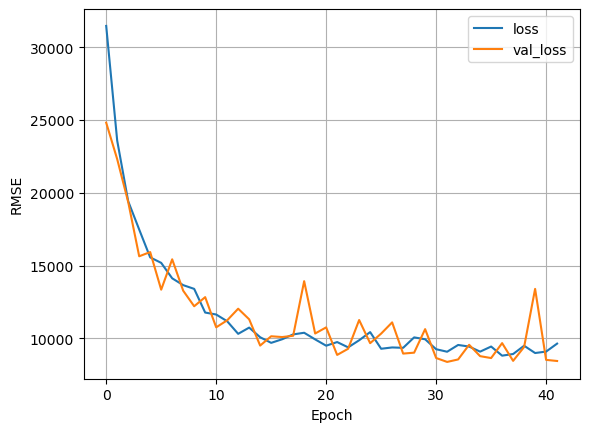

In [60]:
plot_loss(history)

This is by far the best result. I hoped improving it by changing the NN architectures but I was not able to significantly decrease the RMSE with more complex FNNs.

# 4 Conclusion <a id='conclusion'></a>
[to the top](#top)

## 4.1 Summary <a id='summary'></a>
[to the top](#top)

Our goal was to compare different methods in the context of yield prediction. However, the dataset we worked with was not perfect. It didn't contain a lot of history or precision and that makes times series method less efficient. Furthermore, each row contained only three features, which is an issue for machine learning methods. So, it was interesting to wonder what models will perform the best in this context, knowing that obtaining a lot of information is really difficult and costly as we saw during the lectures.

We tested four naive methods : the naive moving one, the moving average and the simple exponential smoothing and the Holt's linear method as well as two ML methods : gradient boosting and feedforward neural networks. 
The FNNs offered the best results, even if I used a very simple architecture. It also benefited from the construction of some new features. It helped to better take into account the past, instead of just the past year. This is the point that really made the ML methods outperform the naive ones, by adding important information.

## 4.2 Further ideas <a id='ideas'></a>
[to the top](#top)

There are few things that could help to improve the performance of our work :
- gather more historical data could improve time series approaches
- gather more information for each data point could improve ML approaches
- spend more time in making a more advanced feature engineering
- understand why the hyperparameter tuning did not succeed for the gradient boosting and apply it on the FNNs
- find a better architecture for the FNNs. I probably lacked knowledge and experience here
- try ensemble learning, combine time series and ML
- test other models, such as SARIMAX or LSTM (with more data)